# The best place to open a japanese restaurant in Rio de Janeiro

Breno S. M. Maia

In [1]:
import pandas as pd
import numpy as np
import folium
import matplotlib.pyplot as plt  
import json
import requests
from pandas.io.json import json_normalize
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn import metrics 
from scipy.spatial.distance import cdist 

### Data Scraping and Cleaning

In [2]:
url = 'https://pt.wikipedia.org/wiki/Lista_de_bairros_do_Rio_de_Janeiro_por_IDH'

dfs = pd.read_html(url, header=0)
df = dfs[1]

In [3]:
Neighborhoods = df[["Bairro ou grupo de bairros", "Renda per capita (em R$ de 2000)"]]
Neighborhoods = Neighborhoods.rename(columns={"Bairro ou grupo de bairros": "Neighbourhood", "Renda per capita (em R$ de 2000)": "Income per capita R$"}, )

In [4]:
Neighborhoods.drop([0], inplace=True)
Neighborhoods.reset_index(drop=True, inplace=True)
Neighborhoods.head()

,Neighbourhood,Income per capita R$
0,Gávea,"2139,56 [b]"
1,Leblon,"2441,28[b]"
2,Jardim Guanabara,"1316,86[a]"
3,Ipanema,"2465,45[b]"
4,Lagoa,"2955,29[b]"


In [ ]:
Neighborhoods['Income per capita R$'] = Neighborhoods['Income per capita R$'].str.replace('[b]', '')
Neighborhoods['Income per capita R$'] = Neighborhoods['Income per capita R$'].str.replace("[[]]", '')
Neighborhoods['Income per capita R$'] = Neighborhoods['Income per capita R$'].str.replace("[a]", '')
Neighborhoods['Income per capita R$'] = Neighborhoods['Income per capita R$'].str.replace("[[]]", '')

In [6]:
Neighborhoods.head(15)

,Neighbourhood,Income per capita R$
0,Gávea,"2139,56"
1,Leblon,"2441,28"
2,Jardim Guanabara,"1316,86"
3,Ipanema,"2465,45"
4,Lagoa,"2955,29"
5,Flamengo,"1781,71"
6,Humaitá,"1830,65"
7,"Barra da Tijuca, Joá","2488,47"
8,Laranjeiras,"1679,22"
9,Jardim Botânico,"1952,77"


For some reason, pandas "read_html" missed the commas in Income per Capita. I fixed that. 

In [7]:
Neighborhoods = pd.read_csv("bairros.csv", names=['Neighbourhood', 'Income per capita R$'])
Neighborhoods.head(15)

,Neighbourhood,Income per capita R$
0,Gávea,"2139,56"
1,Leblon,"2441,28"
2,Jardim Guanabara,"1316,86"
3,Ipanema,"2465,45"
4,Lagoa,"2955,29"
5,Flamengo,"1781,71"
6,Humaitá,"1830,65"
7,"Barra da Tijuca, Joá","2488,47"
8,Laranjeiras,"1679,22"
9,Jardim Botânico,"1952,77"


In [8]:
Neighborhoods.shape

(126, 2)

In [9]:
Neighborhoods['Income per capita R$'] = Neighborhoods['Income per capita R$'].str.replace(',', '.')
Neighborhoods = Neighborhoods.astype({"Income per capita R$": float})

Done! now we have the income per capita for each neighborhood, all cleaned and formated

In [10]:
print("R$",round((Neighborhoods['Income per capita R$'].median()), 2))

R$ 432.54


This was the median income per capita of Rio's neighbourhoods in 2008. Although it is oudated, what matters here is the differences between them, not the absolute value. 
As japanese resaurants are known to be an expansive category, we will narrow our research to the places above the median.

In [11]:
Neighborhoods2 = Neighborhoods.query("`Income per capita R$` >= 432.54")

In [12]:
Neighborhoods2.reset_index(drop=True, inplace=True)
Neighborhoods2.head()

,Neighbourhood,Income per capita R$
0,Gávea,2139.56
1,Leblon,2441.28
2,Jardim Guanabara,1316.86
3,Ipanema,2465.45
4,Lagoa,2955.29


In [13]:
Neighborhoods2.shape

(63, 2)

Now we are working with 63 neighbourhoods!

### Let's get their coodinates

In [14]:
coordinates = pd.read_csv("Coordenadas1.csv", header=0)

In [68]:
coordinates.head()

,Neighborhoods,Latitude,Longitude
0,Gávea,-22.980486,-43.248396
1,Leblon,-22.983729,-43.230051
2,Jardim Guanabara,-22.812196,-43.205437
3,Ipanema,-22.984426,-43.206381
4,Lagoa,-22.962017,-43.207063


In [ ]:
Neighborhoods2['Latitude'] = coordinates['Latitude']
Neighborhoods2['Longitude'] = coordinates['Longitude']

In [70]:
Neighborhoods2 = Neighborhoods2.astype({"Latitude": float, "Longitude": float})
Neighborhoods2.round({"Latitude": 6, "Longitude": 6}).head()

,Neighbourhood,Income per capita R$,Latitude,Longitude
0,Gávea,2139.56,-22.980486,-43.248396
1,Leblon,2441.28,-22.983729,-43.230051
2,Jardim Guanabara,1316.86,-22.812196,-43.205437
3,Ipanema,2465.45,-22.984426,-43.206381
4,Lagoa,2955.29,-22.962017,-43.207063


### Ok, now we can visualize our potential candidates!

In [71]:
map_rio = folium.Map(location=[-22.912142, -43.183189], zoom_start=11)

for lat, lng, label in zip(Neighborhoods2['Latitude'], Neighborhoods2['Longitude'], Neighborhoods2['Neighbourhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_rio)  

map_rio

### Foursquare API

Now that we have the coordinates and income per capita of eah neighbourhood, we will use Foursquare to explore venues. Remember that we are interesed in restaurants, specially the japanese and asian ones.

In [72]:
CLIENT_ID = 'BYFRUWNOZ5XSUPFMMI0OWKITC1PYODPAZEMY1AI1POXWERKA'
CLIENT_SECRET = 'PDI2S42CVYLAYY51KEOI23SXUU5ELRSCXJAGE5LHKVLTL0YK'
VERSION = '20180605' # Foursquare API version


In [73]:
neighborhoods3 = Neighborhoods2
neighborhoods3['Restaurants'] = 0
neighborhoods3['Rate of asian restaurants'] = 0
neighborhoods3.head()

,Neighbourhood,Income per capita R$,Latitude,Longitude,Restaurants,Rate of asian restaurants
0,Gávea,2139.56,-22.980486,-43.248396,0,0
1,Leblon,2441.28,-22.983729,-43.230051,0,0
2,Jardim Guanabara,1316.86,-22.812196,-43.205437,0,0
3,Ipanema,2465.45,-22.984426,-43.206381,0,0
4,Lagoa,2955.29,-22.962017,-43.207063,0,0


In [74]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [75]:
def is_restaurant(df):
    restaurant = 0
    restaurant_words = ['restaurant', 'diner','steakhouse']
    for i in df['categories']:
        i=i.lower()
        for k in restaurant_words:
            if k in i:
                restaurant+=1
    return restaurant
        

In [76]:
def is_asian_restaurant(df):
    similar_restaurants = 0
    direct_competitors  = ['Japanese Restaurant', 'Ramen Restaurant', 'Sushi Restaurant', 'Asian Restaurant']
    for i in df['categories']:
        for k in direct_competitors:
            if k in i:
                similar_restaurants = similar_restaurants + 1
    return similar_restaurants
    

In [83]:
def getNearbyVenues(names, latitudes, longitudes):
    i=0
    LIMIT = 400
    radius = 1600
    for name, lat, lng in zip(names, latitudes, longitudes):
        LIMIT = 100
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        lat, 
        lng,
        radius, 
        LIMIT)
        url
    
        results = requests.get(url).json()
    
        venues = results['response']['groups'][0]['items']
    
        nearby_venues = json_normalize(venues)
    
        filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
        nearby_venues =nearby_venues.loc[:, filtered_columns]

        nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

        nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]
        nearby_venues = nearby_venues.drop(columns=["lat", "lng"])

        #update data frame neighborshoods3
        restaurants = is_restaurant(nearby_venues)
        asian_restaurants = is_asian_restaurant(nearby_venues)
        if restaurants == 0:
            continue
        rate = asian_restaurants / restaurants
    
        neighborhoods3.iloc[[i], [4]] = restaurants
        neighborhoods3.iloc[[i], [5]] = round(rate, 2)
        i = i + 1
        restaurants = 0
    
    return
    

In [82]:
getNearbyVenues(neighborhoods3['Neighbourhood'], neighborhoods3['Latitude'], neighborhoods3['Longitude'])

C:\Users\BrenoMaia\anaconda3\lib\site-packages\ipykernel_launcher.py:21: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead


In [84]:
neighborhoods3.head()

,Neighbourhood,Income per capita R$,Latitude,Longitude,Restaurants,Rate of asian restaurants
0,Gávea,2139.56,-22.980486,-43.248396,9,0.44
1,Leblon,2441.28,-22.983729,-43.230051,18,0.17
2,Jardim Guanabara,1316.86,-22.812196,-43.205437,19,0.11
3,Ipanema,2465.45,-22.984426,-43.206381,22,0.05
4,Lagoa,2955.29,-22.962017,-43.207063,23,0.04


Awesome! Now, before we move on to the clustering, let's drop the neighborhoods in witch Foursquare found less than ten restaurants, because this would wrongly affect the rate of asian restaurants. 

In [85]:
final_df = neighborhoods3.query("Restaurants >= 10")

In [86]:
final_df.reset_index()
final_df.set_index('Neighbourhood', inplace=True)
final_df.head(10)

,Income per capita R$,Latitude,Longitude,Restaurants,Rate of asian restaurants
Neighbourhood,,,,,
Leblon,2441.28,-22.983729,-43.230051,18,0.17
Jardim Guanabara,1316.86,-22.812196,-43.205437,19,0.11
Ipanema,2465.45,-22.984426,-43.206381,22,0.05
Lagoa,2955.29,-22.962017,-43.207063,23,0.04
Flamengo,1781.71,-22.935373,-43.183842,11,0.36
Humaitá,1830.65,-22.955445,-43.206582,22,0.05
"Barra da Tijuca, Joá",2488.47,-22.993477,-43.402400,15,0.27
Laranjeiras,1679.22,-22.935941,-43.197472,10,0.00
Jardim Botânico,1952.77,-22.964323,-43.232207,15,0.27


In [87]:
final_df.shape

(43, 5)

In [88]:
X = final_df[['Income per capita R$', 'Restaurants', 'Rate of asian restaurants']]
X.head()

,Income per capita R$,Restaurants,Rate of asian restaurants
Neighbourhood,,,
Leblon,2441.28,18,0.17
Jardim Guanabara,1316.86,19,0.11
Ipanema,2465.45,22,0.05
Lagoa,2955.29,23,0.04
Flamengo,1781.71,11,0.36


In [89]:
X = StandardScaler().fit_transform(X)

In [90]:
distortions = []
mapping1 = {}
K = range(1,9) 
for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=3).fit(X) 
    kmeanModel.fit(X)     
      
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / X.shape[0]) 
  
    mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_, 
                 'euclidean'),axis=1)) / X.shape[0] 
    

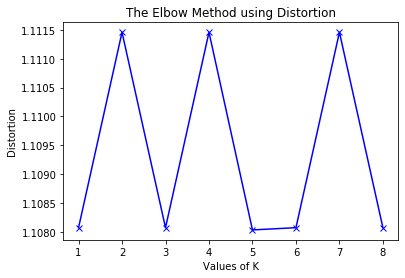

In [91]:
plt.plot(K, distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.show() 

In [92]:
num_clusters = 3

k_means = KMeans(init="k-means++", n_clusters=num_clusters, n_init=12)
k_means.fit(X)
labels = k_means.labels_

print(labels)

[1 1 1 1 2 1 2 1 2 1 1 1 2 1 1 2 1 0 0 1 2 1 0 0 1 0 0 2 0 0 0 2 1 2 2 2 0
 2 0 0 0 0 0]


In [ ]:
final_df["Labels"] = labels
final_df.head(10)

In [111]:
map_clusters = folium.Map(location=[-22.912142, -43.183189], zoom_start=11)

# set color scheme for the clusters
x = np.arange(num_clusters)
ys = [i + x + (i*x)**2 for i in range(num_clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(final_df['Latitude'], final_df['Longitude'], final_df.index, final_df['Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

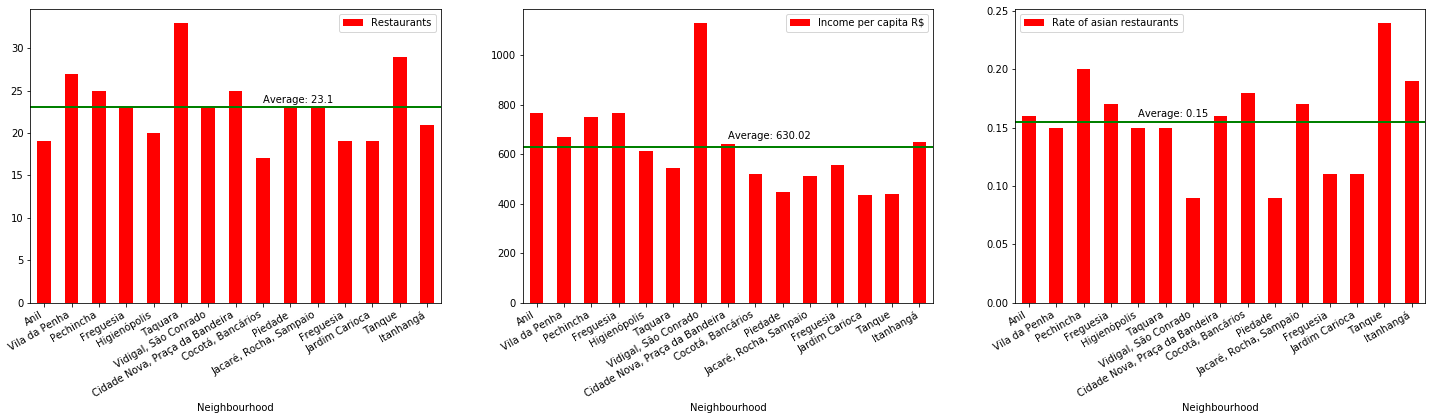

In [170]:
cluster0 = final_df.query("Labels == 0")
cluster0_income = cluster0[['Income per capita R$']]
cluster0_restaurants = cluster0[['Restaurants']]
cluster0_rate = cluster0[['Rate of asian restaurants']]

fig = plt.figure()
ax0 = fig.add_subplot(1, 3, 1) 
ax1 = fig.add_subplot(1, 3, 2)
ax2 = fig.add_subplot(1, 3, 3)

cluster0_restaurants.plot(kind='bar', figsize=(25, 6), color= 'red', ax = ax0)
cluster0_income.plot(kind='bar',figsize=(25, 6), color= 'red',ax = ax1)
cluster0_rate.plot(kind='bar', figsize=(25, 6), color= 'red',ax = ax2)

ax0.axhline(cluster0['Restaurants'].mean(), color='green', linewidth=2)
ax1.axhline(cluster0['Income per capita R$'].mean(), color='green', linewidth=2)
ax2.axhline(cluster0['Rate of asian restaurants'].mean(), color='green', linewidth=2)

ax0.text(8, cluster0['Restaurants'].mean()+0.5, 'Average: {:2.1f}'.format(cluster0['Restaurants'].mean()))
ax1.text(7, cluster0['Income per capita R$'].mean()+30, 'Average: {:3.2f}'.format(cluster0['Income per capita R$'].mean()))
ax2.text(4, cluster0['Rate of asian restaurants'].mean()+0.005, 'Average: {:1.2f}'.format(cluster0['Rate of asian restaurants'].mean()))
fig.autofmt_xdate()

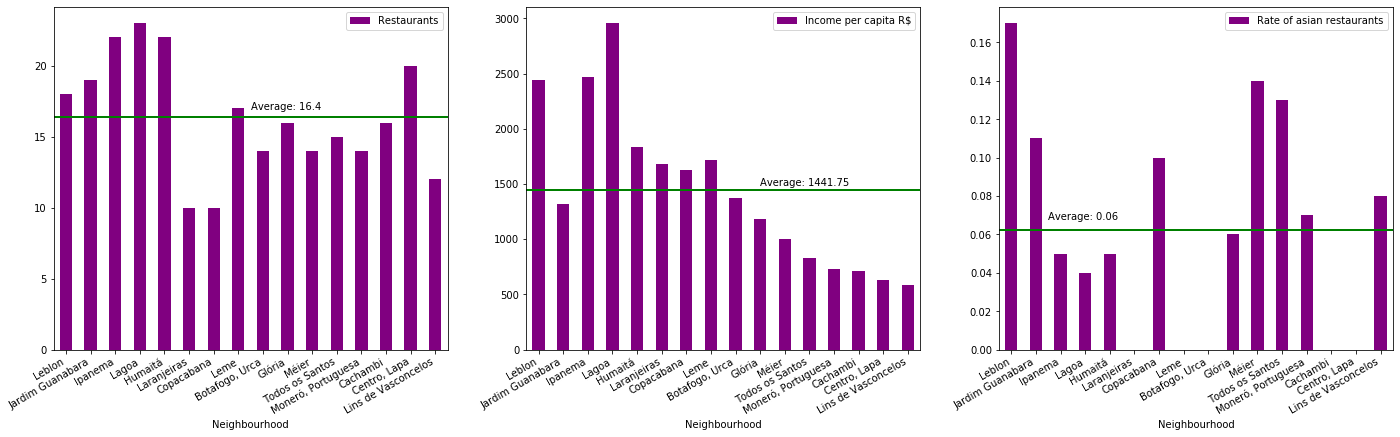

In [168]:
cluster1 = final_df.query("Labels == 1")
cluster1_income = cluster1[['Income per capita R$']]
cluster1_restaurants = cluster1[['Restaurants']]
cluster1_rate = cluster1[['Rate of asian restaurants']]

fig = plt.figure()
ax0 = fig.add_subplot(1, 3, 1) 
ax1 = fig.add_subplot(1, 3, 2)
ax2 = fig.add_subplot(1, 3, 3)

cluster1_restaurants.plot(kind='bar', figsize=(24, 7),color = 'purple', ax = ax0)
cluster1_income.plot(kind='bar',figsize=(24, 7),color = 'purple', ax = ax1)
cluster1_rate.plot(kind='bar', figsize=(24, 7),color = 'purple',ax = ax2)

ax0.axhline(cluster1['Restaurants'].mean(), color='green', linewidth=2)
ax1.axhline(cluster1['Income per capita R$'].mean(), color='green', linewidth=2)
ax2.axhline(cluster1['Rate of asian restaurants'].mean(), color='green', linewidth=2)

ax0.text(7.5, cluster1['Restaurants'].mean()+0.5, 'Average: {:2.1f}'.format(cluster1['Restaurants'].mean()))
ax1.text(9, cluster1['Income per capita R$'].mean()+45, 'Average: {:3.2f}'.format(cluster1['Income per capita R$'].mean()))
ax2.text(1.5, cluster1['Rate of asian restaurants'].mean()+0.005, 'Average: {:1.2f}'.format(cluster1['Rate of asian restaurants'].mean()))
fig.autofmt_xdate()

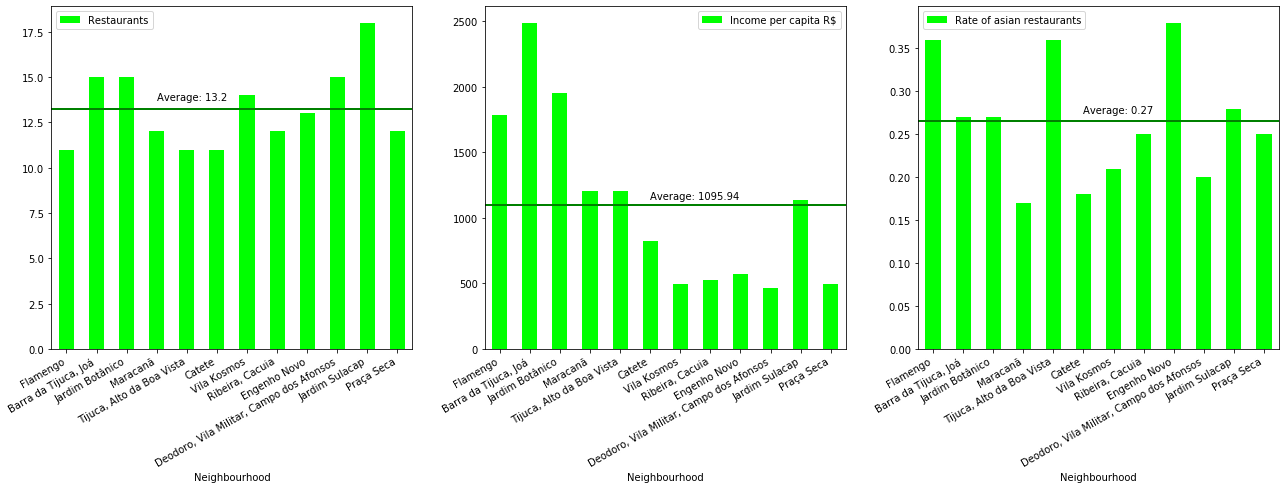

In [166]:
cluster2 = final_df.query("Labels == 2")
cluster2_income = cluster2[['Income per capita R$']]
cluster2_restaurants = cluster2[['Restaurants']]
cluster2_rate = cluster2[['Rate of asian restaurants']]

fig = plt.figure()
ax0 = fig.add_subplot(1, 3, 1) 
ax1 = fig.add_subplot(1, 3, 2)
ax2 = fig.add_subplot(1, 3, 3)

cluster2_restaurants.plot(kind='bar', figsize=(22, 7), color = 'lime', ax = ax0)
cluster2_income.plot(kind='bar',figsize=(22, 7), color = 'lime',ax = ax1)
cluster2_rate.plot(kind='bar', figsize=(22, 7),color = 'lime',ax = ax2)

ax0.axhline(cluster2['Restaurants'].mean(), color='green', linewidth=2)
ax1.axhline(cluster2['Income per capita R$'].mean(), color='green', linewidth=2)
ax2.axhline(cluster2['Rate of asian restaurants'].mean(), color='green', linewidth=2)

ax0.text(3, cluster2['Restaurants'].mean()+0.5, 'Average: {:2.1f}'.format(cluster2['Restaurants'].mean()))
ax1.text(5, cluster2['Income per capita R$'].mean()+50, 'Average: {:3.2f}'.format(cluster2['Income per capita R$'].mean()))
ax2.text(5, cluster2['Rate of asian restaurants'].mean()+0.01, 'Average: {:1.2f}'.format(cluster2['Rate of asian restaurants'].mean()))
fig.autofmt_xdate()

# Conclusion

### Red Cluster
The read cluster sends mixed messages. It has a large number of restaurants, but few of them are direct competitors of ours potential japanese restaurant. Since it is the cluster with the smallest income per capita, it would be interesting considering a low cost approach of japanese cuisine.  Import to note that all neighborhoods analysed are above the median in terms of income.

### Purple CLuster
The purple cluster is the one with the better opportunities. It has the highest income, and very few asian restaurants. A fancy japanese restaurant  in some of these neighborhoods would probably find great demand. 



### Green Cluster
The green cluster is the  worst one for our purposes. Although it has middle-high income, it’s already crowded with asian restaurants. One would likely find very hard competition to a new japanese restaurant in these neighborhoods. 